In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s4e11_path = kagglehub.competition_download('playground-series-s4e11')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Predicting Depression Levels Using Supervised Learning on Mental Health Survey Data

The goal of this project is to use data from a mental health survey to explore factors that may cause individuals to experience depression.

This project uses supervised machine learning to address a binary classification task, where the target variable is *Depression*.

The dataset for this project (both train and test) was generated from a deep learning model trained on the [Depression Survey/Dataset for Analysis dataset](https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis) explores various factors such as sleep duration, dietary habits, academic pressure, professional satisfaction, etc. to identify contributors to depression.

## Data Overview

Let's load train and testing datasets:

In [ ]:
train_file = "/kaggle/input/playground-series-s4e11/train.csv"
test_file = "/kaggle/input/playground-series-s4e11/test.csv"

In [ ]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

#### Feature Descriptions

| Feature | Description| Values |
|---|---|---|
| Name | Participant's name | |
| Gender| Participant's gender | Female, Male |
|Age	| Participant's age | 18 - 60|
|City |	City of residence | |
| Working Professional or Student	| Indicates whether the participant is a working professional or a student | Working Professional, Student|
|Profession	| Participant's current profession.| |
|Academic Pressure	| Level of academic workload | 1-5|
|Work Pressure |	Level of work-related workload | 1-5|
|CGPA	| Cumulative Grade Point Average | 5.03 - 10.00|
|Study Satisfaction|	Satisfaction level with studies | 1-5|
Job Satisfaction|	Satisfaction level with job| 1-5|
| Sleep Duration | Average hours of sleep per night | |
| Dietary Habits|Information about participant’s eating habits ||
|Degree |Highest degree or qualification obtained by the participant ||
|Have you ever had suicidal thoughts?|Indicates if the participant has had suicidal thoughts |Yes, No|
|Work/Study Hours|Average daily hours spent on work or study |0-12|
|Financial Stress|Level of financial stress|1-5|
|Family History of Mental Illness|Indicates if there is a family history of mental illness| Yes, No|
| Depression | Represents whether the participant is at risk of depression | 0, 1|

In [ ]:
train_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
train_shape = train_df.shape
test_shape = test_df.shape
print(f'Number of train dataset rows: {train_shape[0]}, columns: {train_shape[1]}')
print(f'Number of test dataset rows: {test_shape[0]}, columns: {test_shape[1]}')

Number of train dataset rows: 140700, columns: 20
Number of test dataset rows: 93800, columns: 19


In [ ]:
def plot_distributions(df, title):
    df.hist(bins=20, figsize=(16, 10))
    plt.suptitle(title, fontsize=12)
    plt.show()

In [ ]:
train_df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


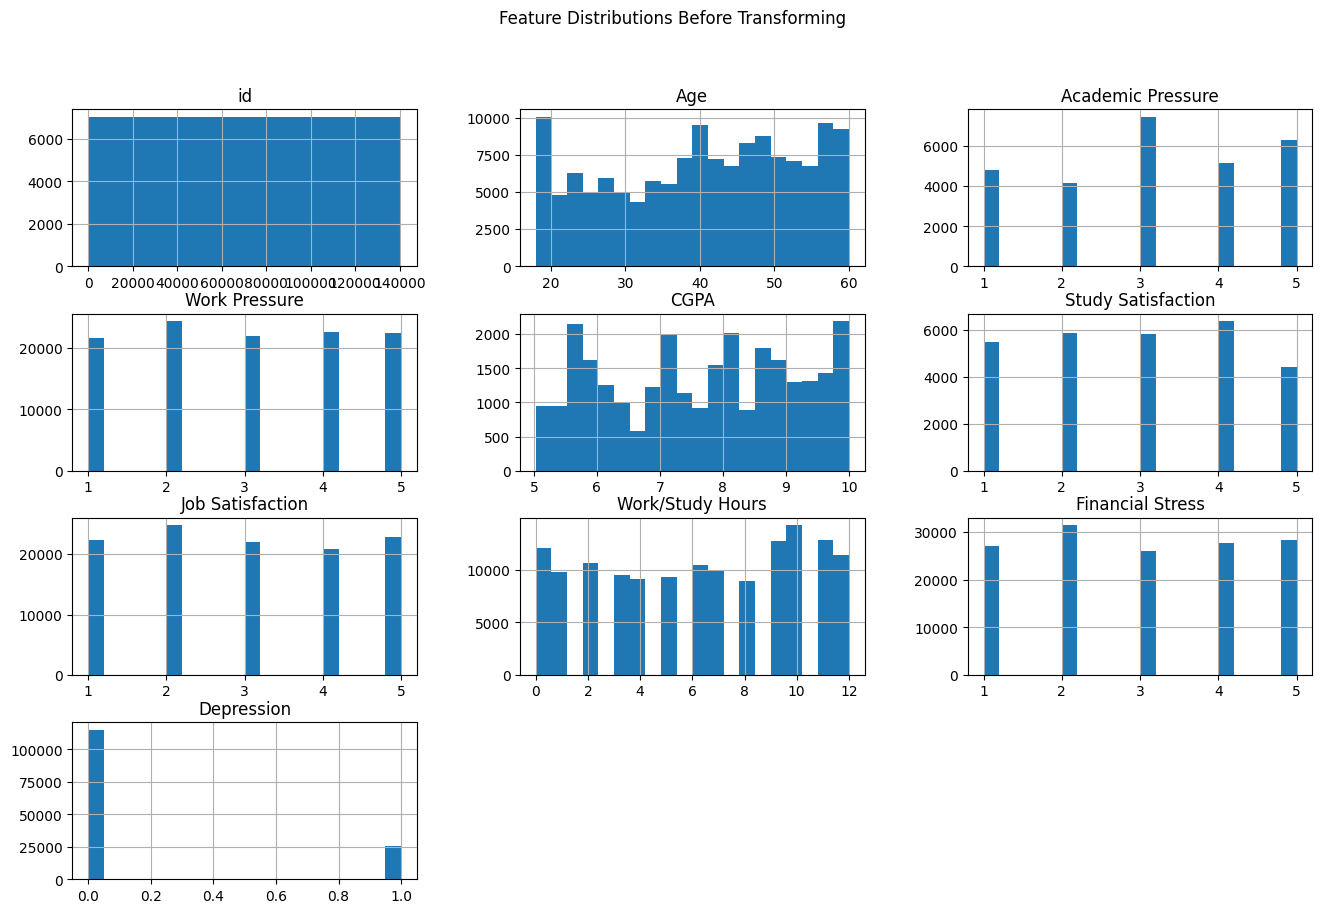

In [ ]:
numeric_columns = list(train_df.select_dtypes(include=['number']))
plot_distributions(train_df[numeric_columns], "Feature Distributions Before Transforming")

#### Age Distribution
Mean age is approximately 40 years with standart deviation of 12, which indicates the mix of younger and middle-aged individuals.
Based on distribution there is large concentration of the youngest group (18-20 years).
#### Academic and Work Pressure Distribution
The mean value is 3.14 for Academic Pressure and 2.99 for Work Pressure. But approximately 80% of the dataset is missing for Academic Pressure because this feature applies only for students.
#### CGPA
The mean value is 7.66 (out of 10).
#### Study and Job Satisfaction
The mean value is near 3 on scale of 1 to 5. But approximately 80% of the dataset is missing for Study Satisfaction because this feature applies only for students.
#### Work/Study Hours
The mean Work/Study Hours is 6.25, with a maximum of 12 hours and a median of 6 hours.
#### Financial Stress
Financial Stress ranges from 1 to 5 with a mean of 2.99. The even distribution (median 3.0) suggests financial pressure may be fairly balanced across the dataset.
#### Depression
About 18% of participants have reported symptoms of depression. The distribution of the Depression is imbalanced, requiring balancing techniques like oversampling or class-weight adjustments for predictive modeling.

Check unique values for each column to understand the future data cleaning strategy:

In [ ]:
for c in train_df.columns[1:]:
    print(c, train_df[c].unique())

Name ['Aaradhya' 'Vivan' 'Yuvraj' 'Rhea' 'Vani' 'Ritvik' 'Rajveer' 'Aishwarya'
 'Simran' 'Utkarsh' 'Aahana' 'Tejas' 'Aadhya' 'Kiran' 'Aditi' 'Suhani'
 'Jiya' 'Bhavesh' 'Armaan' 'Ishaani' 'Prachi' 'Pratyush' 'Abhinav'
 'Siddhesh' 'Aditya' 'Aarav' 'Asha' 'Kashish' 'Prisha' 'Chhavi' 'Tanmay'
 'Vihaan' 'Shiv' 'Anvi' 'Darsh' 'Samar' 'Raunak' 'Mahi' 'Shaurya' 'Vidya'
 'Jai' 'Ayush' 'Ansh' 'Anand' 'Yashvi' 'Shrey' 'Ritika' 'Mihir' 'Isha'
 'Arjun' 'Rohan' 'Pratham' 'Nirvaan' 'Ishaan' 'Aarya' 'Riya' 'Aariv'
 'Raghavendra' 'Mahika' 'Abhishek' 'Harshil' 'Janvi' 'Kartikeya' 'Shivam'
 'Advait' 'Reyansh' 'Saanvi' 'Ivaan' 'Pallavi' 'Sneha' 'Ayaan' 'Aakash'
 'Raghav' 'Satyam' 'Aarush' 'Vibha' 'Rupal' 'Sanya' 'Mira' 'Rashi' 'Shlok'
 'Harsha' 'Divya' 'Pranav' 'Hrithik' 'Tushar' 'Garima' 'Zoya' 'Kian'
 'Navya' 'Lakshay' 'Kriti' 'Palak' 'Aryan' 'Parth' 'Ishan' 'Rupak'
 'Atharv' 'Aarti' 'Anirudh' 'Kabir' 'Sanjeev' 'Sanket' 'Tara' 'Gagan'
 'Anjali' 'Gaurav' 'Vikram' 'Yogesh' 'Ila' 'Rishi' 'Ayansh' 'Kolkata'

#### Unique Counts:
**"Name"** has 422 unique values, indicating potential duplicates or multiple entries for the same individual.

**"City"** has 98 unique values, suggesting a diverse geographical representation.

**"Profession"** has 64 unique values, indicating a variety of professions.

**"Degree"** has 115 unique values, showing a wide range of educational qualifications.

**"Sleep Duration"** has 36 unique values, which might need standardization.

**"Dietary Habits"** has 23 unique values, indicating diverse dietary patterns.

Binary variables like **"Gender," "Working Professional or Student," "Have you ever had suicidal thoughts?", and "Family History of Mental Illness"** have 2 unique values each.

## Data Cleaning

I'll use data preprocessing transformers for data cleaning, transforming, and imputing. These preprocessing steps ensure data consistency, handle missing values intelligently, and prepare features for effective use in machine learning models.

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Drops columns that are either identifiers or redundant.
    Rationale: 'id' and 'Name' are identifiers.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X.drop(['id', 'Name'], axis=1, inplace=True)
        return X


class FixCityName(BaseEstimator, TransformerMixin):
    """
    Cleans city names by mapping miswritten values and handling missing entries.
    Rationale: City column has typos of legitimate city names, some of them appear
    unrecognizable and has educational degrees and numbers, such as M.Tech, 3.0, or MCA.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        cities = [
            "Ludhiana", "Varanasi", "Visakhapatnam", "Mumbai", "Kanpur", "Ahmedabad",
            "Thane", "Nashik", "Bangalore", "Patna", "Rajkot", "Jaipur", "Pune", "Lucknow",
            "Meerut", "Agra", "Surat", "Faridabad", "Hyderabad", "Srinagar", "Ghaziabad",
            "Kolkata", "Chennai", "Kalyan", "Nagpur", "Vadodara", "Vasai-Virar", "Delhi",
            "Bhopal", "Indore"
        ]
        miswritten_cities = {
            "Less Delhi": "Delhi",
            "Molkata": "Kolkata",
            "Tolkata": "Kolkata",
            "Khaziabad": "Ghaziabad",
            "Nalyan": "Kalyan"
        }
        X['City'] = X['City'].map(miswritten_cities)
        X['City'] = X['City'].fillna(train_df['City'])
        X['City'] = X['City'].apply(lambda x: x if x in cities else 'Unknown')

        return X

class FixProfession(BaseEstimator, TransformerMixin):
    """
    Cleans professions by mapping miswritten values and handling missing entries.
    Rationale: Profession column has typos of profession names, some of them appear
    unrecognizable and has irrelevant information.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        professions = [
            'Chef', 'Teacher', 'Business Analyst', 'Finanancial Analyst', 'Chemist',
            'Electrician', 'Software Engineer', 'Data Scientist', 'Plumber',
            'Marketing Manager', 'Accountant', 'Entrepreneur', 'HR Manager',
            'UX/UI Designer', 'Content Writer', 'Educational Consultant',
            'Civil Engineer', 'Manager', 'Pharmacist', 'Financial Analyst', 'Architect',
            'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
            'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
            'Digital Marketer', 'Lawyer', 'Research Analyst', 'Sales Executive', 'Doctor',
            'Unemployed', 'Investment Banker', 'Family Consultant', 'City Manager',
            'Medical Doctor', 'Analyst'
        ]
        X['Profession'] = X['Profession'].apply(lambda x: x if x in professions else 'Unknown')
        return X

class FixAcademicPressure(BaseEstimator, TransformerMixin):
    """
    Imputes missing values based on conditions:
    If the individual is a student with no study hours, academic pressure is set to 0.
    If the individual is a working professional, academic pressure is set to 0.
    Otherwise, a mode value is used.
    Reasoning: These decisions are context-driven, ensuring that missing values align with
    logical expectations for the role.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        condition_1 = (
            (X['Working Professional or Student'] == 'Student') &
            (X['Academic Pressure'].isna()) &
            (X['Work/Study Hours'] == 0)
        )
        condition_2 = (
            (X['Working Professional or Student'] == 'Working Professional')&
            (X['Academic Pressure'].isna())
        )
        condition_3 = (
            (X['Academic Pressure'].isna())
        )

        X.loc[condition_1, 'Academic Pressure'] = 0
        X.loc[condition_2, 'Academic Pressure'] = 0
        X.loc[condition_3, 'Academic Pressure'] = X[X['Working Professional or Student'] == 'Student']['Academic Pressure'].mode()[0]
        return X

class FixWorkPressure(BaseEstimator, TransformerMixin):
    """
    Imputes missing values based on conditions:
    If the individual is a working professional with no work hours, work pressure is set to 0.
    If the individual is a student, work pressure is set to 0.
    Otherwise, a mode value is used.
    Reasoning: These decisions are context-driven, ensuring that missing values align with
    logical expectations for the role.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        condition_1 = (
            (X['Working Professional or Student'] == 'Working Professional') &
            (X['Work Pressure'].isna())
        )
        condition_2 = (
            (X['Working Professional or Student'] == 'Student')&
            (X['Work Pressure'].isna())
        )
        condition_3 = (
            (X['Work Pressure'].isna())
        )

        X.loc[condition_1, 'Work Pressure'] = 0
        X.loc[condition_2, 'Work Pressure'] = 0
        X.loc[condition_3, 'Work Pressure'] = X[X['Working Professional or Student'] == 'Working Professional']['Work Pressure'].mode()[0]
        return X

class SplitWorkingProfessionalsStudents(BaseEstimator, TransformerMixin):
    """
    Split Working Professiona or Student into separate columns.
    Reasoning: Splitting the column into binary columns is better to clarify the scope of academic and work pressure.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Student'] = X['Working Professional or Student'].apply(lambda x: 1 if x == 'Student' else 0)
        X['Working Professional'] = X['Working Professional or Student'].apply(lambda x: 1 if x == 'Working Professional' else 0)
        X = X.drop(columns=['Working Professional or Student'])
        return X


class FixCGPA(BaseEstimator, TransformerMixin):
    """
    Imputes missing values based on conditions:
    If the individual is a student, CGPA is set to mode.
    If the individual is a working professional, CGPA is set to 0.
    Reasoning: Students' CGPAs are assumed to follow the dataset's average trend,
    while CGPA is irrelevant for professionals.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        condition_1 = (
            (X['Working Professional or Student'] == 'Student')&
            (X['CGPA'].isna())
        )
        condition_2 = (
            (X['Working Professional or Student'] == 'Working Professional') &
            (X['CGPA'].isna())
        )

        X.loc[condition_1, 'CGPA'] = X[X['Working Professional or Student'] == 'Student']['CGPA'].mode()[0]
        X.loc[condition_2, 'CGPA'] = 0
        return X


class FixWorkSatisfaction(BaseEstimator, TransformerMixin):
    """
    Imputes missing values based on condition:
    If the individual is a working professional mode value is used.
    Reasoning: These decisions are context-driven, ensuring that missing values align with
    logical expectations for the role.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        condition_1 = (
            (X['Working Professional or Student'] == 'Working Professional') &
            (X['Job Satisfaction'].isna())
        )
        condition_2 = (
            (X['Working Professional or Student'] == 'Student') &
            (X['Job Satisfaction'].isna())
        )

        X.loc[condition_1, 'Job Satisfaction'] = X[X['Working Professional or Student'] == 'Working Professional']['Job Satisfaction'].mode()[0]
        X.loc[condition_2, 'Job Satisfaction'] = 0
        return X

class FixStudySatisfaction(BaseEstimator, TransformerMixin):
    """
    Imputes missing values based on condition:
    If the individual is a student mode value is used.
    Reasoning: These decisions are context-driven, ensuring that missing values align with
    logical expectations for the role.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        condition_1 = (
            (X['Working Professional or Student'] == 'Student') &
            (X['Study Satisfaction'].isna())
        )
        condition_2 = (
            (X['Working Professional or Student'] == 'Working Professional') &
            (X['Study Satisfaction'].isna())
        )

        X.loc[condition_1, 'Study Satisfaction'] = X[X['Working Professional or Student'] == 'Working Professional']['Study Satisfaction'].mode()[0]
        X.loc[condition_2, 'Study Satisfaction'] = 0
        return X

class FixSleepDuration(BaseEstimator, TransformerMixin):
    """
    Corrects using mappings to standardized categories and imputed with 'Unknown' where needed.
    Reasoning: Standardization reduces variability in analysis, and imputing unknown values
    prevents data loss.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        sleep_map = {
            'More than 8 hours': '8+ hours',
            'Less than 5 hours': '< 5 hours',
            '6-8 hours': '6-8 hours',
            '4-6 hours': '5-6 hours',
            '5-6 hours': '5-6 hours',
            '6-7 hours': '6-8 hours',
            '7-8 hours': '6-8 hours',
            '8-9 hours': '8+ hours',
            '9-11 hours': '8+ hours',
            '10-11 hours': '8+ hours',
            '1-2 hours': '< 5 hours',
            '2-3 hours': '< 5 hours',
            '3-4 hours': '< 5 hours',
            '4-5 hours': '< 5 hours',
            '9-5 hours': 'Unknown',
            '10-6 hours': 'Unknown',
            '40-45 hours': 'Unknown',
            '49 hours': 'Unknown',
            'Moderate': 'Unknown',
            'Sleep_Duration': 'Unknown'
        }
        X['Sleep Duration'] = X['Sleep Duration'].map(sleep_map)
        X['Sleep Duration'] = X['Sleep Duration'].fillna('Unknown')
        return X

class FixDietaryHabits(BaseEstimator, TransformerMixin):
    """
    Corrects using mappings to standardized categories and imputed with 'Unknown' where needed.
    Reasoning: Standardization reduces variability in analysis, and imputing unknown values
    prevents data loss.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        diet_map = {
            'Healthy': 'Healthy',
            'Unhealthy': 'Unhealthy',
            'Moderate': 'Moderate',
            'More Healthy': 'Healthy',
            'Less Healthy': 'Unhealthy',
            'Less than Healthy': 'Unhealthy',
            'No Healthy': 'Unhealthy',
            'Hormonal': 'Unhealthy',
            'Yes': 'Unknown',
            'No': 'Unknown'
        }
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_map)
        X['Dietary Habits'] = X['Dietary Habits'].fillna('Unknown')
        return X

class FixDegree(BaseEstimator, TransformerMixin):
    """
    Cleans degrees by mapping miswritten values and handling missing entries.
    Rationale: Degrees column has typos, some of them appear
    unrecognizable and has irrelevant information.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        valid_degrees = [
            'BHM', 'LLB', 'B.Pharm', 'BBA', 'BSc', 'B.Arch', 'BE', 'BCA', 'B.Com', 'B.Tech',
            'MBA', 'M.Com', 'M.Tech', 'MA', 'M.Ed', 'MCA', 'MSc', 'PhD', 'MD', 'M.Arch', 'MPA',
            'Class 12', 'Class 11'
        ]

        degree_mapping = {
            'B.Sc': 'BSc',
            'BPharm': 'B.Pharm',
            'BEd': 'B.Ed',
            'MTech': 'M.Tech',
            'MPharm': 'M.Pharm',
            'LLM': 'LL.B',
            'LLTech': 'LL.B',
            'B.B.Arch': 'B.Arch',
            'B BA': 'BBA',
            'LL.Com': 'LL.B',
            'LLS': 'LL.B',
            'P.Com': 'B.Com',
            'H_Pharm': 'B.Pharm',
            'LHM': 'MHM',
            'S.Tech': 'B.Tech',
            'M_Tech': 'M.Tech'
        }
        X['Degree'] = X['Degree'].map(degree_mapping).fillna(X['Degree'])
        X['Degree'] = X['Degree'].apply(lambda x: x if x in valid_degrees else 'Unknown')
        return X

class FixFinancialStress(BaseEstimator, TransformerMixin):
    """
    Imputes missing values with the median.
    Reasoning: Median is a robust measure for central tendency
    and handles skewed distributions effectively.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        condition = (
            (X['Financial Stress'].isna())
        )
        X.loc[condition, 'Financial Stress'] = X['Financial Stress'].median()

        return X

class OrdinalEncode(BaseEstimator, TransformerMixin):
    """
    Transforms specific categorical features into ordinal (ordered) numerical values.
    """
    def fit(self, X, y=None):
        sleep_duration_order = ['8+ hours', '6-8 hours', '5-6 hours', '< 5 hours']
        dietary_habits_order = ['Healthy', 'Moderate', 'Unhealthy']
        self.ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[dietary_habits_order, sleep_duration_order])
        self.ordinal_encoder.fit(X[['Dietary Habits', 'Sleep Duration']])
        return self

    def transform(self, X):
        X = X.copy()
        X[['Dietary Habits', 'Sleep Duration']] = self.ordinal_encoder.transform(X[['Dietary Habits', 'Sleep Duration']])
        return X

class OneHotEncode(BaseEstimator, TransformerMixin):
    """
    Performs one-hot encoding on categorical features to create binary indicator variables.
    """
    def fit(self, X, y=None):
        self.one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        self.one_hot_encoder.fit(X[['City', 'Profession', 'Degree']])
        return self

    def transform(self, X):
        X = X.copy()
        ohe_columns = self.one_hot_encoder.transform(X[['City', 'Profession', 'Degree']])
        ohe_df = pd.DataFrame(ohe_columns, columns=self.one_hot_encoder.get_feature_names_out(['City', 'Profession', 'Degree']), index=X.index)
        X = pd.concat([X, ohe_df], axis=1)
        X.drop(['City', 'Profession', 'Degree'], axis=1, inplace=True)
        return X

class BinaryConversion(BaseEstimator, TransformerMixin):
    """
    Converts binary categorical features into numerical (0/1) format for analysis.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Gender'] = X['Gender'].map({'Female': 0, 'Male': 1})
        X['Have you ever had suicidal thoughts ?'] = X['Have you ever had suicidal thoughts ?'].map({'No': 0, 'Yes': 1})
        X['Family History of Mental Illness'] = X['Family History of Mental Illness'].map({'No': 0, 'Yes': 1})
        return X

class Normalization(BaseEstimator, TransformerMixin):
    """
    Scales all numerical features to a range between 0 and 1 using Min-Max scaling.
    Reasoning: Normalization needed for sensitive to feature scales models (e.g., k-NN, SVM).
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        scaler = MinMaxScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        return X

In [ ]:
preprocessing_pipeline = Pipeline([
    ('fix_city_name', FixCityName()),
    ('fix_profession', FixProfession()),
    ('fix_work_satisfaction', FixWorkSatisfaction()),
    ('fix_study_satisfaction', FixStudySatisfaction()),
    ('fix_academic_pressure', FixAcademicPressure()),
    ('fix_work_pressure', FixWorkPressure()),
    ('fix_cgpa', FixCGPA()),
    ('fix_sleep_duration', FixSleepDuration()),
    ('fix_dietary_habits', FixDietaryHabits()),
    ('fix_degree', FixDegree()),
    ('fix_financial_stress', FixFinancialStress()),
    ('split_roles', SplitWorkingProfessionalsStudents()),
    ('binary_conversion', BinaryConversion()),
    ('ordinal_encode', OrdinalEncode()),
    ('one_hot_encode', OneHotEncode()),
    ('drop_columns', DropColumns()),
    ('normalization', Normalization())
])

In [ ]:
train_transformed = preprocessing_pipeline.fit_transform(train_df)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**Summary**: The data cleaning process includes standardization, imputing, and transformation raw input data for a mental health-related dataset. Were created custom transformers for handling missing values, standardization of categorical variables, normalization of numerical features, and feature engineering.

## EDA (After data transforming)
### General Overview

In [ ]:
train_transformed.shape

(140700, 112)

The dataset contains 140700 rows and 112 columns

In [ ]:
def visualize_missing_values(df, title):
    plt.figure(figsize=(10, 6))
    missing = df.isnull().sum()
    print(f'Columns with missing data: {missing}')
    missing.plot.bar()
    plt.title(title)
    plt.ylabel("Number of Missing Values")
    plt.xlabel("Features")
    plt.show()

Columns with missing data: id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64


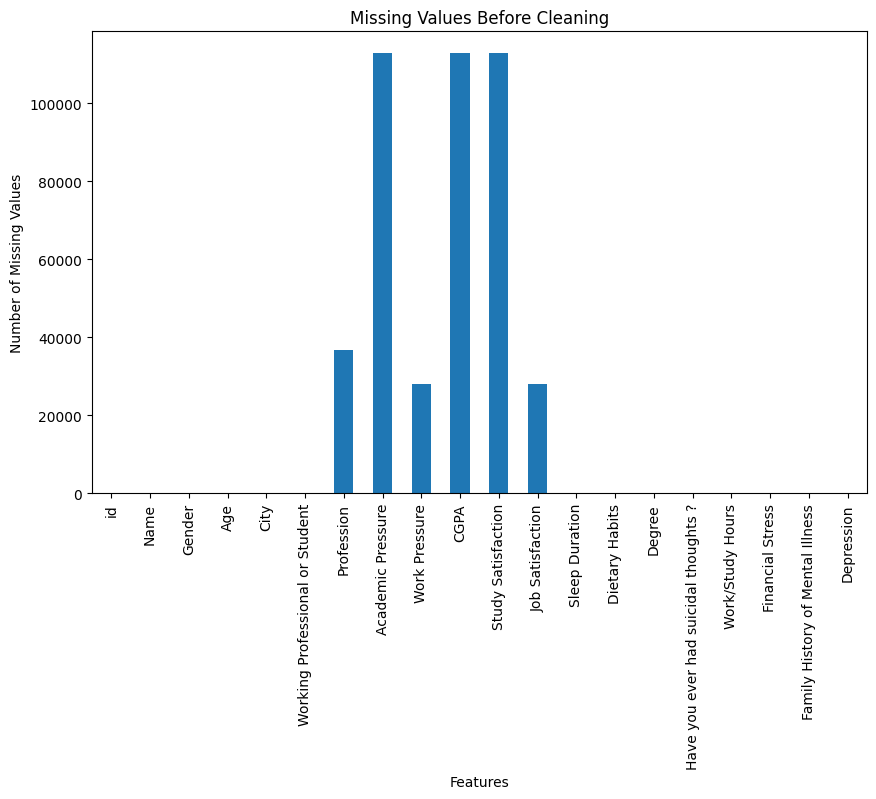

Columns with missing data: Gender                                   0
Age                                      0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Student                                  0
Working Professional                     0
dtype: int64


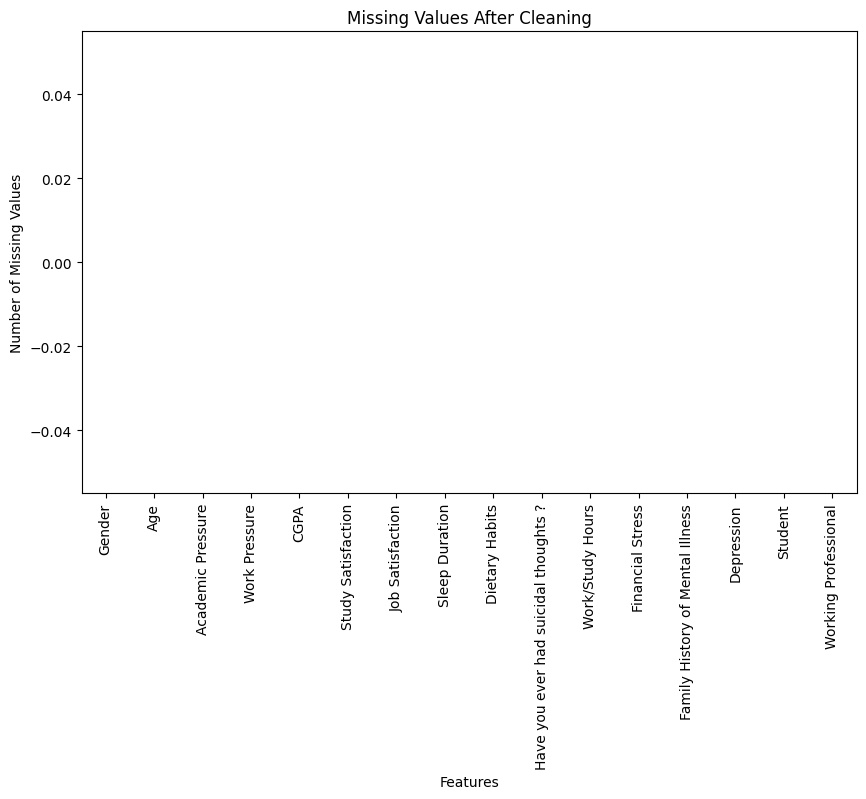

In [ ]:
columns = list(train_df.columns)
# 'id', 'Name' removed
# 'City', 'Profession', 'Degree' one-hot encoded
# 'Working Professional or Student' is split to 'Working Professional' and 'Student'
to_remove = ['id', 'Name', 'City', 'Profession', 'Working Professional or Student', 'Degree']
columns = [c for c in columns if c not in to_remove]
columns.append('Student')
columns.append('Working Professional')

visualize_missing_values(train_df, "Missing Values Before Cleaning")
visualize_missing_values(train_transformed[columns], "Missing Values After Cleaning")

### Data Types and NA values (all features)

All columns has **float64** data type after preprocessing. Let's check it:

In [ ]:
non_float_dtype_columns = [c for c, t in train_transformed.dtypes.items() if t != 'float']
if non_float_dtype_columns != []:
    print(non_float_dtype_columns)
else:
    print('All columns has float64 data type.')

All columns has float64 data type.


Check if any of column has NA value:

In [ ]:
na_values = [c for c, v in train_transformed.isnull().any().items() if v == True]
if na_values != []:
    print(na_values)
else:
    print('No NA values in dataset.')

No NA values in dataset.


### Feature Distribution

Let's check feature distributions after transformation (without one-hot encoded values):

In [ ]:
train_transformed.describe()

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,...,Degree_M.Ed,Degree_M.Tech,Degree_MA,Degree_MBA,Degree_MCA,Degree_MD,Degree_MPA,Degree_MSc,Degree_PhD,Degree_Unknown
count,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,...,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000
mean,0.550561,0.533062,0.507052,0.450194,0.151907,0.116809,0.476925,0.636764,0.670092,0.494399,...,0.040284,0.031819,0.020519,0.027136,0.037200,0.024044,0.000007,0.034677,0.022054,0.246773
std,0.497439,0.294860,0.154323,0.330038,0.312281,0.264240,0.347198,0.281297,0.268137,0.499970,...,0.196626,0.175520,0.141767,0.162480,0.189252,0.153187,0.002666,0.182960,0.146860,0.431135
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.261905,0.500000,0.250000,0.000000,0.000000,0.200000,0.500000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.571429,0.500000,0.250000,0.000000,0.000000,0.400000,0.750000,0.666667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.785714,0.500000,0.750000,0.000000,0.000000,0.800000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


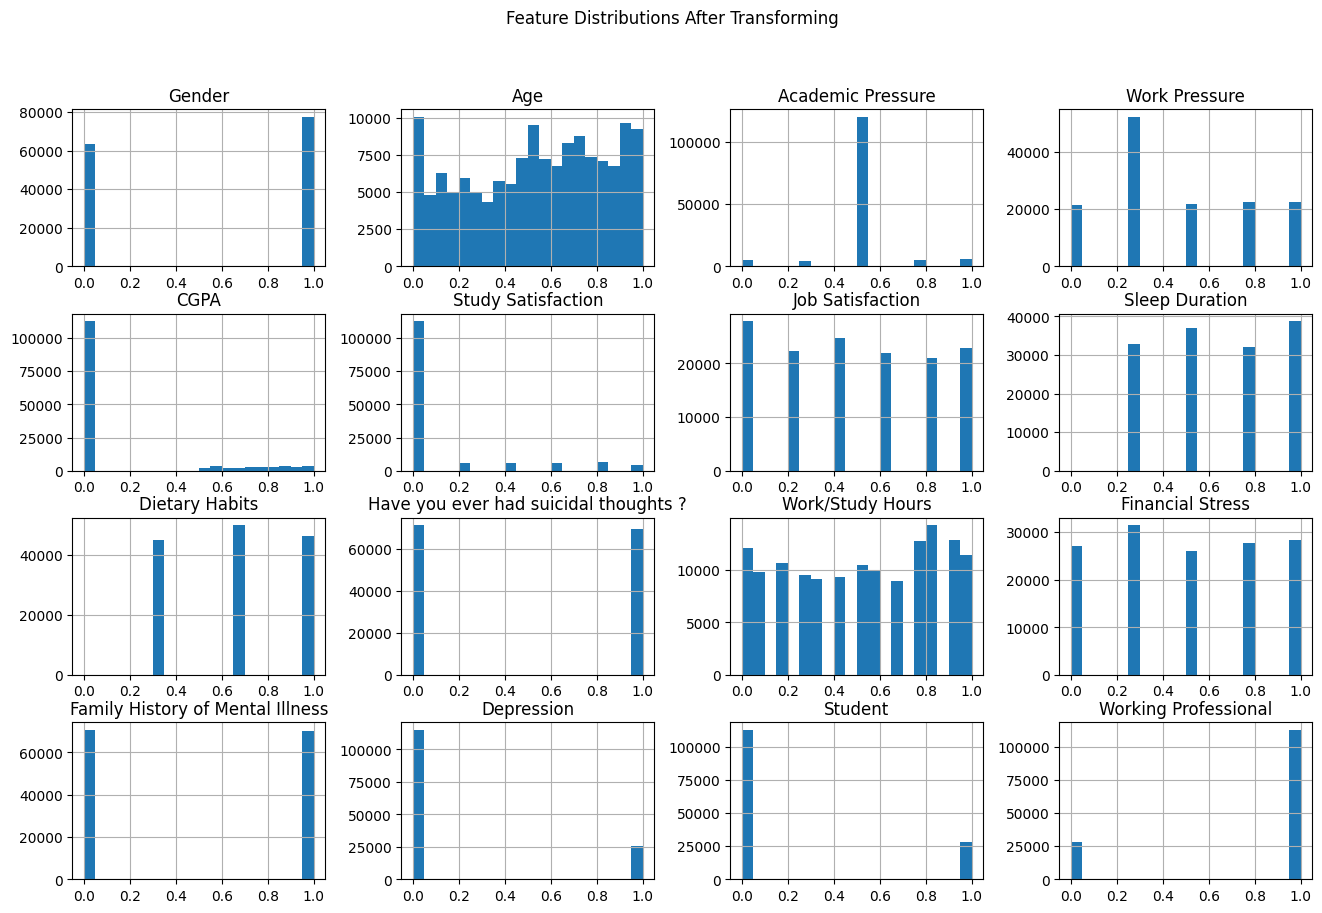

In [ ]:
plot_distributions(train_transformed[columns], "Feature Distributions After Transforming")

As we can see, normalization was correctly implemented for each feature.

**Gender**, **Depression**, **Working Professional**, **Student**, **CGPA**, **Study Satisfaction** has a significant imbalance, with one class being much more prevalent.

**Age** demonstrates a relatively uniform distribution across the range, indicating effective scaling.

### Correlation

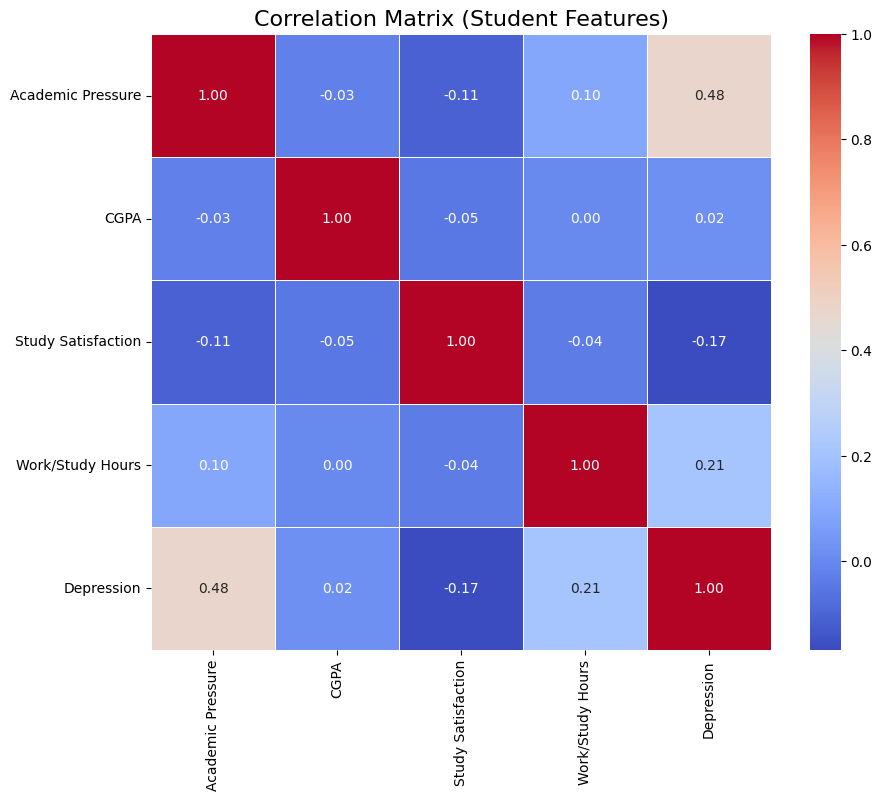

In [ ]:
student_train_transformed = train_transformed[train_transformed['Student'] == 1]
student_columns = ['Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours', 'Depression']
correlation_matrix = student_train_transformed[student_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix (Student Features)', fontsize=16)
plt.show()

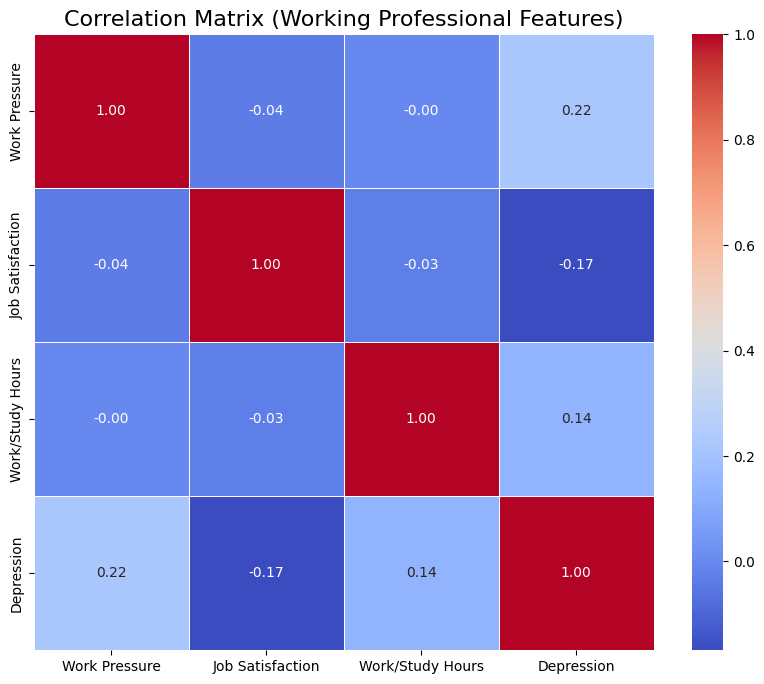

In [ ]:
wp_train_transformed = train_transformed[train_transformed['Working Professional'] == 1]
wp_columns = ['Work Pressure', 'Job Satisfaction', 'Work/Study Hours', 'Depression']
correlation_matrix = wp_train_transformed[wp_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix (Working Professional Features)', fontsize=16)
plt.show()

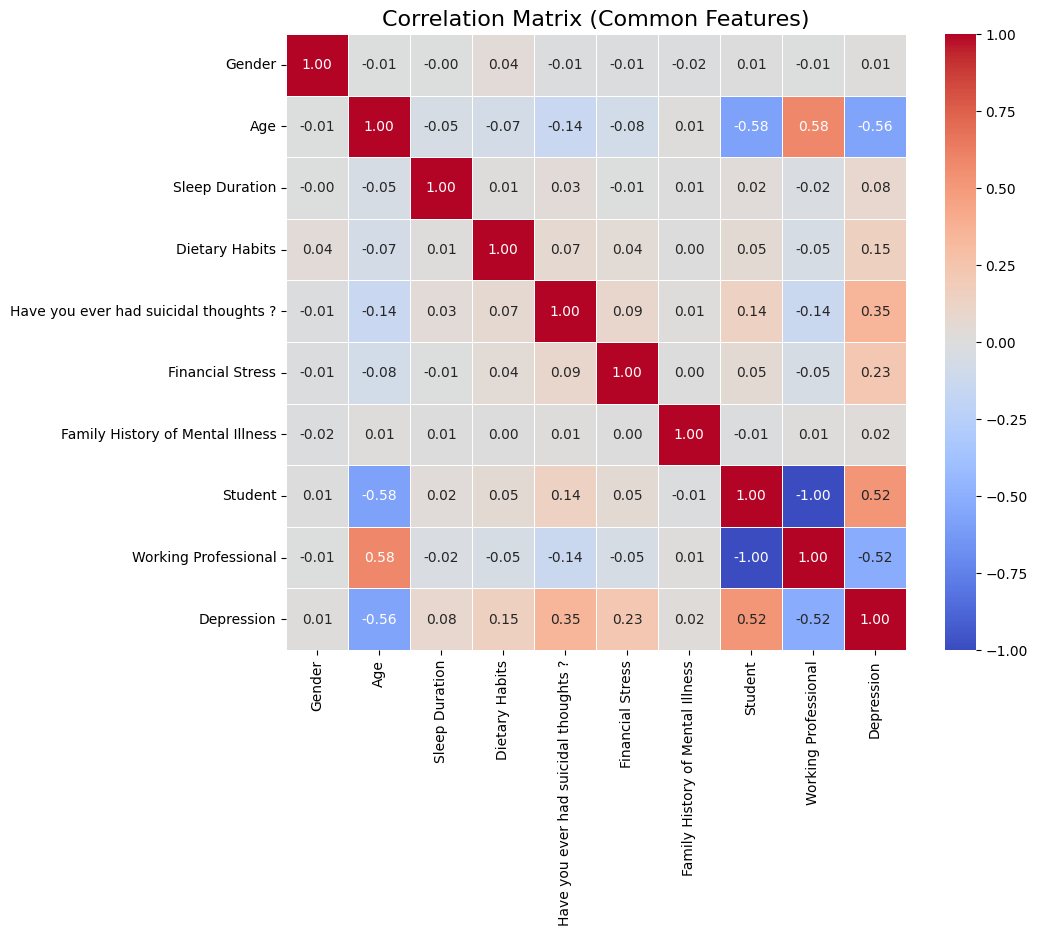

In [ ]:
common_columns = ['Gender', 'Age', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness', 'Student', 'Working Professional', 'Depression']
correlation_matrix = train_transformed[common_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix (Common Features)', fontsize=16)
plt.show()

#### Strong Negative Correlation:
**Age** and **Depression** (-0.56), suggesting that younger individuals might have higher depression scores.

**Working Professional** and **Depression** (-0.52), suggesting that working professional are less likely to experience depression.

#### Strong Positive Correlation:
**Academic Pressure** and **Depression** (0.48) shows that high academic pressure could be a factor contributing to depression.

**Student** and **Depression** (0.52), suggesting that Students are more likely to experience depression.

#### Moderate Positive Correlation:
**Have you ever had suicidal thoughts?** and **Depression** (0.35), suggesting that individuals with suicidal thoughts are likely to experience depression.

**Financial Stress** and **Depression** (0.23) indicates that economic stain could contribute to mental health struggles.

**Work Pressure** and **Depression** (0.22), suggesting that working professional with higher work pressure are more likely to experience depression.

**Work/Study Hours** (for Students) and **Depression** (0.21), suggesting that Students with higher study hours are more likely to experience depression.


## Model

Split data into train and test and select a **Depression** feature as target value:

In [ ]:
y = train_transformed['Depression']
X = train_transformed.drop(columns=['Depression'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset is imbalanced, apply SMOTE to the training data

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Use GridSearchCV to find the best parameters for LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, CatBoostClassifier models.

In [ ]:

param_grids = {
#     'lr': {
#         'C': [0.01, 0.1, 1, 10, 100],
#         'penalty': ['l1', 'l2'],
#         'solver': ['liblinear', 'lbfgs'],
#         'max_iter': [100, 500, 1000]
#     },
#     'rf': {
#         'n_estimators': [100, 200],  # Number of trees in the forest
#         'max_depth': [10, 20],        # Maximum depth of the trees
#         'min_samples_split': [2, 5],  # Minimum samples required to split an internal node
#         'min_samples_leaf': [1, 2],   # Minimum samples required to be at a leaf node
#         'criterion': ['gini'],       # Quality of a split (gini or entropy)
#         'bootstrap': [True],          # Whether to use bootstrapping
#     },
#     'xgb': {
#         'n_estimators': [100, 200],  # Number of boosting rounds (trees)
#         'learning_rate': [0.05, 0.1],  # Step size at each iteration
#         'max_depth': [3, 5],          # Maximum depth of each tree
#         'subsample': [0.8, 1.0],      # Fraction of samples to use for each tree
#         'colsample_bytree': [0.8, 1.0],  # Fraction of features to use for each tree
#         'objective': ['binary:logistic'],  # Binary classification objective
#     },
    'knn': {
        'n_neighbors': [5, 7],
        'weights': ['uniform'],
        'algorithm': ['auto'],
    },
#     'dt': {
#         'max_depth': [5, 10],  # Maximum depth of the tree
#         'min_samples_split': [2, 5],     # Minimum samples to split a node
#         'min_samples_leaf': [1, 2],       # Minimum samples at a leaf node
#         'criterion': ['gini'],  # Split criterion
#     },
#     'cat': {
#         'iterations': [100, 200],  # Number of boosting iterations (trees)
#         'learning_rate': [0.05, 0.1],  # Step size in each iteration
#         'depth': [6, 8],  # Depth of trees
#         'l2_leaf_reg': [1, 3],  # L2 regularization term
#         'bagging_temperature': [0.5, 1.0],  # Controls the intensity of bagging (subsampling)
#         'max_bin': [100, 255],  # Maximum number of bins to use for numerical features
#     }
}
for model, params in param_grids.items():
    if model == 'lr':
        estimator = LogisticRegression()
    elif model == 'knn':
        estimator = KNeighborsClassifier()
#     elif model == 'dt':
#         estimator = DecisionTreeClassifier()
#     elif model == 'rf':
#         estimator = RandomForestClassifier()
#     elif model == 'xgb':
#         estimator = XGBClassifier()
#     elif model == 'cat':
#         estimator = CatBoostClassifier(verbose=0)

    grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=params,
            cv=3,
            scoring='accuracy',
            verbose=1
    )

    grid_search.fit(X_resampled, y_resampled)
    y_pred = grid_search.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred)

    print("Model: ", model)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    print("Best Test Accuracy:", accuracy_test)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


Result of GridSearchCV:

|Model|Cross-Validation Accuracy|Parameters|
|---|---|---|
|RandomForestClassifier|0.9518|{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}|
|XGBClassifier|0.9439|{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 1.0}|
|DecisionTreeClassifier|0.9361|{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}|
|CatBoostClassifier|0.9328|{'bagging_temperature': 0.5, 'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'max_bin': 255}|
|LogisticRegression|0.9320|{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}|
|KNeighborsClassifier|0.9113|{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}|



Use VotingClassifier ensemble for model training:

In [ ]:
lr_params = {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
best_lr = LogisticRegression(**lr_params)

#knn_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
#best_knn = KNeighborsClassifier(**knn_params)

dt_params = {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
best_dt = DecisionTreeClassifier(**dt_params)

xgb_params = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 1.0}
best_xgb = XGBClassifier(**xgb_params)

rf_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best_rf = RandomForestClassifier(**rf_params)

catboost_params = {'bagging_temperature': 0.5, 'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'max_bin': 255}
best_catboost = CatBoostClassifier(**catboost_params)

In [ ]:
voting_clf = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('dt', best_dt),
    ('rf', best_rf),
    ('catboost', best_catboost)
], voting='soft')

voting_clf.fit(X_resampled, y_resampled)

In [ ]:
cv_scores = cross_val_score(voting_clf, X_resampled, y_resampled, cv=3, scoring='accuracy')
cv_scores

Plot ROC curve:

Check accuracy for test dataset:

In [ ]:
y_pred = voting_clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_test

In [ ]:
ypp = voting_clf.predict_proba(X_test)
fpr, tpr, th = roc_curve(y_test, ypp[:, 1])
auc = roc_auc_score(y_test, ypp[:, 1])

plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, f'AUC={round(auc, 3)}')

In [ ]:
test_transformed = preprocessing_pipeline.transform(test_df)

In [ ]:
pred = voting_clf.predict(test_transformed)

submission = pd.DataFrame({
    'id': test_df['id'],
    'Depression': pred
})
submission.to_csv('submission.csv', index=False)